# Desafío de Clase 24: Ingeniería de atributos y selección de variables.

En el presente desafío seguiremos utilizando la base de información usual de transacciones o pedidos realizados en un negocio de Ecommerce tradicional enfocado a la venta de mercancíás generales.

El objetivo del proyecto es poder crear un modelo que nos permita predecir el Churn del cliente, es decir, si nos terminará realizando una compra para un periodo particular.

El enfoque de este análisis consiste en calcular las siguientes variables de manera recursiva:

1. **Edad:** Tiempo transcurrido (días) entre la primer compra y un punto de corte.
2. **Monetary value:** Venta promedio que un cliente ha generado a través de una fecha de corte.
3. **Frequency:** Número de pedidos generados antes de una fecha de corte. 
4. **Recency:** Diferencía en días entre la compra más reciente y un punto de corte.

Posteriormente al cálculo de estas métricas, utilizarémos un modelo de Machine Learning: RandomForest para poder hacer la predición de Churn de nuestra base de clientes.

In [1]:
#Configuración y lectura de datos. También imprimimos una muestra de las columnas para ver como se estructura la información. 
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.style.use("bmh")
warnings.filterwarnings("ignore")

route = "C:/Users/abrah/Documents/"

df = pd.read_csv(route + "Ecommerce_Transactions_2021.csv", sep = '|', encoding = 'UTF8') #Leemos nuestros datos através de un archivo CSV e imprimios las columnas contenidas así como su data type que manejan por default.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16692886 entries, 0 to 16692885
Data columns (total 98 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   Unnamed: 0                            int64  
 1   Almacen de Origen                     object 
 2   Almacen detalle                       object 
 3   banco                                 object 
 4   Bandera bundle final                  object 
 5   Bandera CBT                           object 
 6   Bandera pagos                         object 
 7   canal                                 object 
 8   Canal_formato_SO                      object 
 9   cantidad                              int64  
 10  Carrier                               object 
 11  CATEGORIA                             object 
 12  Categoria ecomm                       object 
 13  CLICK AND COLLECT                     object 
 14  codigo postal                         float64
 15  Comision MKP 

## Feature Engineering

En el siguiente proceso, creamos nuevos campos o features adicionales sobre la base oríginal, tratamos los tipos de datos de algúnas variables y agrupamos nuestra base de informacción orifinal a **nivel cliente** con cada uno de los campos señalados.

In [2]:
## Transforma los tipos de datos oríginales de las distintas variables a los tipos que necesitamos para manipular la información. 
df["FECHA DE CREACION"] = pd.to_datetime(df["FECHA DE CREACION"], format  = "%Y-%m-%d")
df["Fecha de confirmacion"] = pd.to_datetime(df["Fecha de confirmacion"], format  = "%Y-%m-%d")
df["Fecha de cancelacion"] = pd.to_datetime(df["Fecha de cancelacion"], format  = "%Y-%m-%d")
df["FECHA DE CREACION CON HORA"] = pd.to_datetime(df["FECHA DE CREACION CON HORA"],format= '%Y-%m-%d %H:%M:%S')
#df["fecha de embarque"] = pd.to_datetime(df["fecha de embarque"], format  = "%Y-%m-%d")
#df["Fecha de entrega"] = pd.to_datetime(df["Fecha de entrega"], format  = "%Y-%m-%d")
#df["Fecha maxima de entrega"] = pd.to_datetime(df["Fecha maxima de entrega"], format  = "%Y-%m-%d")
#df["Fecha minima de entrega"] = pd.to_datetime(df["Fecha minima de entrega"], format  = "%Y-%m-%d")

df["Año"] = df["FECHA DE CREACION"].dt.year
df["Mes"] = df["FECHA DE CREACION"].dt.month
df["Dia"] = df["FECHA DE CREACION"].dt.day

#Simple imputting process. 
df["Venta bruta sin descuentos con flete"] = df["Venta bruta sin descuentos con flete"].fillna(0)
df["cantidad"] = df["cantidad"].fillna(0)
df["Piezas canceladas"] = df["Piezas canceladas"].fillna(0)
df["Venta cancelada"] = df["Venta cancelada"].fillna(0)
df["Total_venta"] = df["Venta bruta sin descuentos con flete"] + df["Venta cancelada"]
df["Total_piezas"] = df["Piezas canceladas"] + df["cantidad"]

In [3]:
# Filtramos la información de un año hacía atrás, es decir, de Junio 2022 hasta Mayo 2023. También, consideramos solo aquellos pedidos que tuvieron un pago confirmado.
#df = df.loc[df.loc[:,"FECHA DE CREACION"] > "2022-06-01",:]
df = df.loc[df.loc[:,"Fecha de confirmacion"].notna(),:]

In [4]:
df_customer = df.groupby(["FECHA DE CREACION","Año","Mes","Customer_ID","Order_ID"]).agg({'Total_venta': np.sum,'Total_piezas': np.sum}).reset_index()
df_customer.head(10) #Imprimimos nuestra base de información resultante.

,FECHA DE CREACION,Año,Mes,Customer_ID,Order_ID,Total_venta,Total_piezas
0,2021-01-01,2021,1,C1000395,Order_6601912,11620.690000,2.0
1,2021-01-01,2021,1,C1002490,Order_6600223,5765.510000,1.0
2,2021-01-01,2021,1,C1003767,Order_6553751,5170.697928,2.0
3,2021-01-01,2021,1,C1004681,Order_6603468,9849.140000,1.0
4,2021-01-01,2021,1,C100613,Order_6600045,775.001034,1.0
5,2021-01-01,2021,1,C1007224,Order_6602121,1119.831034,1.0
6,2021-01-01,2021,1,C1009042,Order_6599055,2372.413103,1.0
7,2021-01-01,2021,1,C1012964,Order_6603997,2697.360000,1.0
8,2021-01-01,2021,1,C1014466,Order_6597681,1033.621034,1.0
9,2021-01-01,2021,1,C1014610,Order_6603470,5594.830000,1.0


Nueva estructura de df_customer

In [5]:
#Renombramos los campos o columnas para tener mejor estructura de nuestra base de información.
df_customer = df.groupby(["FECHA DE CREACION","Año","Mes","Customer_ID","Order_ID"]).agg({'Total_venta': np.sum, 'Total_piezas': np.sum,
        'Venta bruta sin descuentos con flete': np.sum, 'Flete': np.sum, 'Total descuentos': np.sum, 'Venta cancelada': np.sum, 'Piezas canceladas':np.sum}).reset_index()

df_customer.rename(columns={'FECHA DE CREACION':'Fecha','Total_venta':"Venta",'Total_piezas': "Piezas",'Venta bruta sin descuentos con flete': 'Venta_pagada','Flete':'Costo_envio'
,'Total descuentos':'Total_descuentos','Venta cancelada':'Venta_cancelada'
,'Piezas canceladas':'Piezas_canceladas'}, inplace=True)

df_customer.head(10)

,Fecha,Año,Mes,Customer_ID,Order_ID,Venta,Piezas,Venta_pagada,Costo_envio,Total_descuentos,Venta_cancelada,Piezas_canceladas
0,2021-01-01,2021,1,C1000395,Order_6601912,11620.690000,2.0,11620.690000,0.000000,3032.76,0.0,0.0
1,2021-01-01,2021,1,C1002490,Order_6600223,5765.510000,1.0,5765.510000,84.480000,0.00,0.0,0.0
2,2021-01-01,2021,1,C1003767,Order_6553751,5170.697928,2.0,5170.697928,0.004828,1706.90,0.0,0.0
3,2021-01-01,2021,1,C1004681,Order_6603468,9849.140000,1.0,9849.140000,0.000000,0.00,0.0,0.0
4,2021-01-01,2021,1,C100613,Order_6600045,775.001034,1.0,775.001034,0.001034,301.72,0.0,0.0
5,2021-01-01,2021,1,C1007224,Order_6602121,1119.831034,1.0,1119.831034,0.001034,0.00,0.0,0.0
6,2021-01-01,2021,1,C1009042,Order_6599055,2372.413103,1.0,2372.413103,0.003103,0.00,0.0,0.0
7,2021-01-01,2021,1,C1012964,Order_6603997,2697.360000,1.0,2697.360000,119.780000,344.83,0.0,0.0
8,2021-01-01,2021,1,C1014466,Order_6597681,1033.621034,1.0,1033.621034,0.001034,431.04,0.0,0.0
9,2021-01-01,2021,1,C1014610,Order_6603470,5594.830000,1.0,5594.830000,0.000000,1731.89,0.0,0.0


### Cálculo de variables: Age, Recency , Frequency & Monetary value (RFM)

Para el cálculo del Churn, se utilizará un modelo recursivo de RFM, es decir, iterarémos sobre cada una de las fechas de corte del algoritmo para obtener las variables del modelo de RFM antes de la fecha de corte establecida y tomaremos aquellos cleintes con engagemente para los cuales hayan realizado una compra **un mes después**.

Antes tener nuestra base de información original, mostraremos algunas reglas de cálculo de las variables del RFM.

#### Recency

In [6]:
cut_off = df_customer.loc[:,"Fecha"].max()
recency = df_customer.loc[df_customer.loc[:,"Fecha"] < cut_off, :].copy()

recency = recency.groupby(["Customer_ID"]).agg({'Fecha':'max'}).reset_index().rename(columns={"Fecha":"LastPurchaseDate"})
recency["Recency"] = ((cut_off - recency.LastPurchaseDate).dt.days)
recency.head()

,Customer_ID,LastPurchaseDate,Recency
0,C100000,2023-06-06,4
1,C1000000,2023-06-04,6
2,C1000011,2023-03-02,100
3,C1000017,2023-03-27,75
4,C1000021,2022-11-04,218


#### Purchase Frequency

In [17]:
cut_off = df_customer.Fecha.max()
frequency = df_customer.loc[df_customer.loc[:,"Fecha"] < cut_off,:].copy()
frequency.drop(columns=["Año","Mes"], inplace=True)

frequency.set_index("Fecha", inplace=True)
frequency.index = pd.DatetimeIndex(frequency.index)

frequency_t = frequency.groupby(["Customer_ID", pd.Grouper(freq="M", level="Fecha")]).count()
frequency_t["value_column"] = 1

frequency_t = frequency_t.groupby(["Customer_ID"]).sum().reset_index().rename(columns={'value_column':'Frequency'})

frequency_t = frequency_t.loc[:,["Customer_ID","Frequency"]]
frequency_t.head()


,Customer_ID,Frequency
0,C100000,6
1,C1000000,3
2,C1000011,1
3,C1000017,2
4,C1000021,1


#### Monetary Value

In [18]:
cut_off = df_customer.Fecha.max()
mvalue = df_customer.loc[df_customer.loc[:,"Fecha"] < cut_off,:].copy()
mvalue.drop(columns=["Año","Mes"], inplace=True)

#Set date columns as index.
mvalue.set_index(mvalue.Fecha, inplace=True)
mvalue.index = pd.DatetimeIndex(mvalue.index)

mvalue_avg = mvalue.groupby(["Customer_ID"])["Venta"].mean().reset_index().rename(columns={"Venta":'Average_sales'})
mvalue_total = mvalue.groupby(["Customer_ID"])["Venta"].sum().reset_index().rename(columns={"Venta":'Total_sales'})

mvalue = pd.concat([mvalue_avg, mvalue_total], axis=1)
mvalue = mvalue.loc[:,["Customer_ID","Average_sales","Total_sales"]]

mvalue.head()

,Customer_ID,Customer_ID,Average_sales,Total_sales
0,C100000,C100000,5839.516310,58395.163103
1,C1000000,C1000000,11545.139540,34635.418621
2,C1000011,C1000011,3792.230000,3792.230000
3,C1000017,C1000017,2046.551379,4093.102759
4,C1000021,C1000021,6430.167241,6430.167241


#### Age

In [19]:
cut_off = df_customer.Fecha.max()
age = df_customer.loc[df_customer.loc[:,"Fecha"] < cut_off,:].copy()
age.drop(columns=["Año","Mes"], inplace=True)

age = age.groupby(["Customer_ID"])["Fecha"].min().reset_index()
age["age"] = (cut_off - age.Fecha).dt.days

age.head()

,Customer_ID,Fecha,age
0,C100000,2022-11-16,206
1,C1000000,2022-08-27,287
2,C1000011,2023-03-02,100
3,C1000017,2022-07-30,315
4,C1000021,2022-11-04,218


#### Definición de funciones para el cálculo de los atributos del modelo RFM y Otras variables adicionales para el cálculo del Churn 

Dado que tenemos un proceso iterativo que irá calculando dichas features entre periodos, se construye una función que permita obtener una base con estas características ya calculadas.

Las funciones que se construyeron son las siguientes:

In [6]:
def customer_recency(df_customer, cut_off):
    #cut_off = df.loc[:,"Fecha"].max()
    recency = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off, :].copy()
    recency = recency.groupby(["Customer_ID"]).agg({'Fecha':'max'}).reset_index().rename(columns={"Fecha":"LastPurchaseDate"})
    recency["Recency"] = ((cut_off - recency.LastPurchaseDate).dt.days)

    return recency.loc[:,["Customer_ID","Recency"]]

def customer_frequency_1(df_customer, cut_off):

    frequency = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    frequency.drop(columns=["Año","Mes"], inplace=True)

    frequency.set_index("Fecha", inplace=True)
    frequency.index = pd.DatetimeIndex(frequency.index)

    frequency_t = frequency.groupby(["Customer_ID", pd.Grouper(freq="M", level="Fecha")]).count()
    frequency_t["value_column"] = 1

    return frequency_t.groupby(["Customer_ID"]).sum().reset_index().rename(columns={'value_column':'Frequency'}).loc[:,["Customer_ID","Frequency"]]

def customer_frequency(df_customer, cut_off):

    frequency = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    frequency.drop(columns=["Año","Mes"], inplace=True)

    frequency = frequency.groupby(["Customer_ID"]).agg({'Order_ID':lambda x: x.nunique()}).reset_index().rename(columns = {'Order_ID':'Frequency'})

    return frequency.loc[:,["Customer_ID","Frequency"]]

def customer_monetaryvalue(df_customer, cut_off):

    mvalue = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    mvalue.drop(columns=["Año","Mes"], inplace=True)

    #Set date columns as index.
    mvalue.set_index(mvalue.Fecha, inplace=True)
    mvalue.index = pd.DatetimeIndex(mvalue.index)

    mvalue_avg = mvalue.groupby(["Customer_ID"])["Venta"].mean().reset_index().rename(columns={"Venta":'Average_sales'})
    mvalue_total = mvalue.groupby(["Customer_ID"])["Venta"].sum().reset_index().rename(columns={"Venta":'Total_sales'})

    mvalue = pd.concat([mvalue_avg, mvalue_total], axis=1)
    mvalue = mvalue.loc[:,["Customer_ID","Average_sales","Total_sales"]]
    
    return mvalue.iloc[:,1:]
    
def customer_age(df_customer, cut_off):
    
    age = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    age.drop(columns=["Año","Mes"], inplace=True)

    age = age.groupby(["Customer_ID"])["Fecha"].min().reset_index()
    age["Age"] = (cut_off - age.Fecha).dt.days
 
    return age.loc[:,["Customer_ID","Age"]]

def customer_cancellations(df_customer, cut_off):
    #We only focuse on the number of pieces cancelled, not the amount of monetary value. The latter could lead to bias because of the nature on regarst to our customer purchase behavior.  
    df_cancellations = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    df_cancellations.drop(columns=["Año","Mes"], inplace=True)

    df_cancellations = df_cancellations.groupby(["Customer_ID"])["Piezas","Piezas_canceladas"].sum().reset_index()
    df_cancellations.loc[:,"Ratio_cancellations"] = df_cancellations.Piezas_canceladas / df_cancellations.Piezas 
    
    return df_cancellations.loc[:,["Customer_ID","Ratio_cancellations"]]
    
def customer_basket_size(df_customer, cut_off):
    #We only focused in the number of pieces cancelled, not the amount of monetary value. 
    df_bs = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    df_bs.drop(columns=["Año","Mes"], inplace=True)

    df_bs = df_bs.groupby(["Customer_ID"]).agg({'Piezas': np.sum , 'Order_ID': lambda x: x.nunique()}).reset_index().rename(columns = {'Order_ID':'Ordenes'})
    df_bs.loc[:,"Basket_size"] = df_bs.Piezas / df_bs.Ordenes 
    
    return df_bs.loc[:,["Customer_ID","Basket_size"]]

def customer_shipping_ratio(df_customer, cut_off):
    #We only focused in the number of pieces cancelled, not the amount of monetary value. 
    df_sr = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    df_sr.drop(columns= ["Año","Mes"], inplace=True)

    df_sr = df_sr.groupby(["Customer_ID"]).agg({'Costo_envio': np.sum,'Venta_pagada': np.sum}).reset_index()
    df_sr.loc[:,"Shipping_ratio"] = df_sr.Costo_envio / df_sr.Venta_pagada 
    
    return df_sr.loc[:,["Customer_ID","Shipping_ratio"]]

def customer_discount_ratio(df_customer, cut_off):
    #We only focused in the number of pieces cancelled, not the amount of monetary value. 
    df_dr = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    df_dr.drop(columns= ["Año","Mes"], inplace=True)

    df_dr = df_dr.groupby(["Customer_ID"]).agg({'Total_descuentos': np.sum,'Venta_pagada': np.sum}).reset_index()
    df_dr.loc[:,"Discount_ratio"] = df_dr.Total_descuentos / (df_dr.Venta_pagada + df_dr.Total_descuentos) 
    
    return df_dr.loc[:,["Customer_ID","Discount_ratio"]]

def customer_rfm(df_customer, cut_off):

    recency = customer_recency(df_customer, cut_off)
    frequency = customer_frequency(df_customer, cut_off)
    monetary_value = customer_monetaryvalue(df_customer, cut_off)
    age = customer_age(df_customer, cut_off)
    
    #Here, we add the additional variables.
    cancellations = customer_cancellations(df_customer, cut_off)
    basket_size = customer_basket_size(df_customer, cut_off)
    shipping_ratio = customer_shipping_ratio(df_customer, cut_off)
    discount_ratio = customer_discount_ratio(df_customer, cut_off)

    return pd.merge(left=recency, right=frequency, how='left', left_on= "Customer_ID", right_on="Customer_ID").merge(monetary_value, on="Customer_ID").merge(age, on = "Customer_ID").merge(cancellations, on = "Customer_ID").merge(basket_size, on = "Customer_ID").merge(shipping_ratio, on = "Customer_ID").merge(discount_ratio, on = "Customer_ID")


Testing de obtención de los atributos del modelo de RFM.

In [7]:
cut_off = df_customer.Fecha.max()
rfm_features = customer_rfm(df_customer, cut_off)

In [8]:
#Imprime un sample de como luce la información. 
rfm_features

,Customer_ID,Recency,Frequency,Average_sales,Total_sales,Age,Ratio_cancellations,Basket_size,Shipping_ratio,Discount_ratio
0,C1,576,1,128.450000,128.450000,576,0.0,1.000000,0.000000e+00,0.850849
1,C10000,630,1,9481.892759,9481.892759,630,0.0,1.000000,2.909357e-07,0.120010
2,C100000,4,10,5839.516310,58395.163103,206,0.0,1.300000,7.986674e-03,0.283161
3,C1000000,6,7,7309.119409,51163.835862,888,0.0,1.285714,2.325194e-03,0.125778
4,C1000002,417,3,1023.338851,3070.016552,529,0.0,1.666667,2.134101e-06,0.063630
...,...,...,...,...,...,...,...,...,...,...
5430819,C999991,40,3,3785.686207,11357.058621,200,0.0,1.000000,1.039870e-02,0.132363
5430820,C999992,575,1,4134.480000,4134.480000,575,0.0,4.000000,0.000000e+00,0.215826
5430821,C999994,135,2,5619.051724,11238.103448,148,0.0,1.000000,5.983523e-03,0.099461
5430822,C999997,637,1,3987.100000,3987.100000,637,0.0,1.000000,0.000000e+00,0.000003


In [7]:
#Esta función solo nos funciona para poder asignar la etiqueta "1" sobre aquellos clientes que realizaron una compra entre el punto del corte y un mes después. 
def churn_label(future):
    future['DidBuy'] = 1
    return future.loc[:,["Customer_ID","DidBuy"]].drop_duplicates()

#### Construcción de la base de información para el entrenamiento del modelo. 

Dentro del siguiente proceso, irémos de manera mensual o mes a mes construyendo las variables de etiqueta de CHunr a través del campo "DidBuy" y las demás variables del enfoque RFM.

EL propósito de iterar sobre múltiples periodos es para capturar los efectos de temporalidad y estacionalidad que impactan o se reflejan dentro del comportmamiento del cliente. Con esto, realizaríamos un análisis de Churn con múltiples periodos. La frecuencia de análisis se haría de forma mensual y el dataset final es un consolidado con los atributos del RFM y Labels de Chunrn para cada periodo de análisis

El periodo de iteración comprende desde Junio 2022 hasta el 2023, por lo que de manera mensual o mes a mes, irémos calculando las etiqutas de Churn y las caracterías del enfoque del RFM.

Definición de rangos de fechas con 3 Meses

In [8]:
start_length = 90
label_period_days = 90

dset_list = list()
#Rules for start measuring this information

# We will be predicting customer Churn by Q's, so, the very beggining data for analytis would be Jan 1 of any year. 
start_date = df_customer.loc[:,["Fecha"]].min() 
end_date = df_customer.loc[:,["Fecha"]].max() 

dates = pd.date_range(start=start_date[0], end=end_date[0], freq='Q')
#df_customer.Fecha = pd.to_datetime(df_customer.Fecha, format = "%Y-%m-%d") 

In [9]:
for cut_off in dates:
    #observed = df_customer.loc[df_customer.Fecha <= cut_off,:]
    future = df_customer.loc[(df_customer.Fecha > cut_off) & (df_customer.Fecha < cut_off + pd.Timedelta(label_period_days, unit='D')),:]

    rfm_sdate = cut_off
    rfm_edate = cut_off + pd.Timedelta(label_period_days, unit='D')

    print(f"Computing rfm features for {cut_off} to {rfm_edate}")

    #Obtenemos las características RFM de los clientes. 
    rfm_features = customer_rfm(df_customer, cut_off)
    labels = churn_label(future)

    dset = pd.merge(left= rfm_features, right=labels, how='outer', left_on="Customer_ID",right_on="Customer_ID").fillna(0)
    dset_list.append(dset)

#Concatenamos todos los datasets
full_dataset = pd.concat(dset_list, axis = 0)
res = full_dataset.loc[full_dataset.Recency != 0,:].dropna(axis = 1, how = 'any')

Computing rfm features for 2021-03-31 00:00:00 to 2021-06-29 00:00:00
Computing rfm features for 2021-06-30 00:00:00 to 2021-09-28 00:00:00
Computing rfm features for 2021-09-30 00:00:00 to 2021-12-29 00:00:00
Computing rfm features for 2021-12-31 00:00:00 to 2022-03-31 00:00:00
Computing rfm features for 2022-03-31 00:00:00 to 2022-06-29 00:00:00
Computing rfm features for 2022-06-30 00:00:00 to 2022-09-28 00:00:00
Computing rfm features for 2022-09-30 00:00:00 to 2022-12-29 00:00:00
Computing rfm features for 2022-12-31 00:00:00 to 2023-03-31 00:00:00
Computing rfm features for 2023-03-31 00:00:00 to 2023-06-29 00:00:00


In [10]:
res

,Customer_ID,Recency,Frequency,Average_sales,Total_sales,Age,Ratio_cancellations,Basket_size,Shipping_ratio,Discount_ratio,DidBuy
0,C1000000,87.0,1.0,1033.610000,1033.610000,87.0,0.0,1.0,0.000000e+00,0.000010,1.0
1,C1000007,80.0,1.0,11874.120000,11874.120000,80.0,0.0,2.0,1.408441e-02,0.153621,0.0
2,C1000020,34.0,1.0,6801.710000,6801.710000,34.0,0.0,1.0,0.000000e+00,0.122360,0.0
3,C1000021,36.0,1.0,4783.623793,4783.623793,36.0,0.0,1.0,7.929351e-07,0.000000,0.0
4,C1000024,53.0,1.0,654.311034,654.311034,53.0,0.0,1.0,1.581026e-06,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4990822,C999991,129.0,1.0,4205.340690,4205.340690,129.0,0.0,1.0,7.994760e-03,0.198719,1.0
4990823,C999992,504.0,1.0,4134.480000,4134.480000,504.0,0.0,4.0,0.000000e+00,0.215826,0.0
4990824,C999994,64.0,2.0,5619.051724,11238.103448,77.0,0.0,1.0,5.983523e-03,0.099461,0.0
4990825,C999997,566.0,1.0,3987.100000,3987.100000,566.0,0.0,1.0,0.000000e+00,0.000003,0.0


## **Entrenamientos de Modelo de Machine Learning**


Antes de pasar al entrenamiento del modelo de ML, se harán algunos procesos adicionales de tratamiento de información como lo es el uso de MinMaxScaler para escalar los datos entre los rango de 1 y 0.

Dado que nuenuestra base de información, en cada una de las variables del enfoque RFM no poseen una distribución normal, se considera usar el procesamiento a través del MinMaxScaler.

Seperando nuestros datos en conjunto de **entrenamiento**, **test** y aplicación de escalamiento de datos (MinMaxScaler).

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

rec_df = res.sample(frac=1)

# Obtenemos la matriz de datos o features y la matriz de respuesta.
X = rec_df.loc[:,["Recency","Frequency","Average_sales","Age","Ratio_cancellations","Basket_size","Shipping_ratio","Discount_ratio"]].values
y = rec_df.loc[:,["DidBuy"]].values.reshape(-1)

#Aplicamos el método fit_transform a través de Min-Max Scaler para  transformar nuestros datos. 
scaler = MinMaxScaler()
X_scale  = scaler.fit_transform(X)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=test_size, random_state=42, shuffle=True)

### SMOTE - Atacando el problema de desbalanceo en nuestra base de información. 
Importante, observemos  lo siguiente:

In [11]:
rec_df.DidBuy.value_counts()

0.0    23247981
1.0     2933452
Name: DidBuy, dtype: int64

Como se observa, alrededor de del 7.8% de las observaciones son aquellos clientes que han realizado una compra en los periodos futuros de observación, mientras que el 92.2% de los cliente no realizaron una compra **(Churn)**

La clase minoría en este caso son los **clientes con compra**.
La clase mayorista eran los **clientes sin compra** o **clientes con Churn**.

Así, tenemos un problema de **clases imbalanceadas**. 

Para atacar el problmea anterior, usarémos una técnica denominada SMOTE (Synthetic Minotiry Oversampling Technique). Lo que harémos es hacer sampling para tener más registros de la clase minorísta , es decir, de aquellos **clientes con compra**. 



In [11]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [13]:
pd.Series(y_train_over).value_counts()

0.0    18599576
1.0    18599576
dtype: int64

Se realizó un oversampling de la clase minoría para así tratar de arreglar el problema de desbalanceo. 

Nuestra proporción de clases ahora está 50 - 50.

### **Entrenamiento del 1er modelo de Machine Learning : BAGGING METHOD - RANDOM FORESTS**

En este caso, utilizaremos métodos de ensamblaje para entrenar nuestro modelo de Machine Learning y así entrender cuales son los clientes con mayor riesgo de presentar **Churn.**

Este problema es del tipo supervisadO por lo que el Modelo utilizado será el siguiente: **Random Forest**

También, se entrenan dos modelos: Una base con el conjunto de información original y otro con SMOTE aplicado. Esto, para reducir el sesgo producido por el problema de desbalanceo.  

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

#Entrenamos el modelo sobre la base de información imbalanceada
rf = RandomForestClassifier().fit(X_train,y_train)

#Entrenamos el modelo sobre la nueva base con la clase minoría con oversampling | SMOTE
rf_over = RandomForestClassifier().fit(X_train_over, y_train_over)

#### Evaluación del Modelo de clasificación de Random Forests. 

Accuracy assessment: En base al modelo anterior, harémos las predicciones correspondiente sobre el dataset de muestra y training y así revisar **Accuracy** de clasificiación. 

In [39]:
# Guaradmos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = rf.predict(X_train)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = rf.predict(X_test)
predictions_test['preds_over'] = rf_over.predict(X_test)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")

Accuary datos entrenamiento: 0.9731, Accuracy datos Test: 0.9157, Accuracy test Oversampled: 0.7824


Cómo se observa, tenemos un alto accuracy de en el dataset de entrenamiento, lo cual nos daría el problema de desbalanceo al tener una clase predominante. En el set de test, vemos un acccuracy de 0.91, mientras que con el conjunto de entrenamiento con SMOTE para atacar el desbalanceo tenemos un accuracy de 0.78%. 

Matríz de confusión sobre datos sin **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

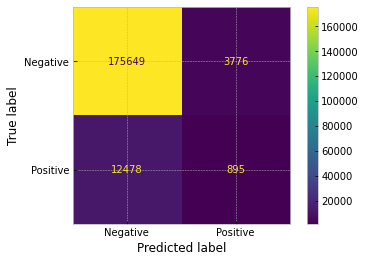

In [40]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(rf, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos con **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

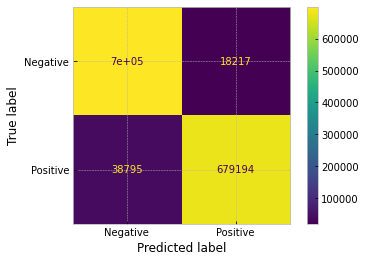

In [41]:
# Graficamos una matriz de confusión con los datos de oversampling SMOTE
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(rf_over, X_test, y_test, display_labels=['Negative', 'Positive'])

Reporte de Precision - Recall - F1 Score | **Datos sin oversampling - SMOTE**


In [42]:
#Imprimimos todas las métricas en 1 - Sobre base de información sin algoritmo de SMOTE para atacar desbalanceo
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96    179425
         1.0       0.19      0.07      0.10     13373

    accuracy                           0.92    192798
   macro avg       0.56      0.52      0.53    192798
weighted avg       0.88      0.92      0.90    192798



Reporte de Precision - Recall - F1 Score | **Datos con oversampling - SMOTE**


In [43]:
#Imprimimos todas las métricas en 1
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.94      0.82      0.87    179425
         1.0       0.12      0.32      0.17     13373

    accuracy                           0.78    192798
   macro avg       0.53      0.57      0.52    192798
weighted avg       0.88      0.78      0.83    192798



**Resultados**

Dataset sin SMOTE u oversampling:

Nuestro precision asciende a 0.92, con lo cual, tenemos buen accuracy de predicción de clases, en este caso, clientes con Churn. Cabe destacar que este alto accuracy se debería al problema de desbalanceo, donde la clase dominante son aquellos clientes de Churn con más del 90%. 

El F1 score de la clase positiva (clientes que compran o no Churn) es muy bajo , **0.10**, mientras que de la clase negativa (Churn) vemos que es de **0.96**. 

Por otra parte, vemos que en la base de información con SMOTE aplicado para desbalanceo, nuestro accuracy disminuye hasta **0.78**. El F1 score de la clase positiva aumenta a **0.17** y el de la clase negativa disminuye a **0.87**.

Vemos que con el Oversampling, vemos un buen performance en términos de **F1 Score** y **Accuracy**, por lo que tomaremos esta versión de oversampling para aislar el problema de desbalanceo. 

### **Entrenamiento del 2do modelo de Machine Learning : BOOSTING METHODS - XGBoost**

In [14]:
import xgboost as xgb

#Entrenamos el modelo sobre la base de información imbalanceada
xgb_model =  xgb.XGBClassifier(n_estimators = 100, learning_rate = 0.1, random_state = 42)

#We train over the data set that is not oversampled.
xgb_model_no = xgb_model.fit(X_train, y_train)

#We train over the data set is oversampled.
xgb_model_wo = xgb_model.fit(X_train_over, y_train_over)


#### Evaluación del Modelo de clasificación de XGBoost. 

In [15]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Guaradmos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = xgb_model_no.predict(X_train)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = xgb_model_no.predict(X_test)
predictions_test['preds_over'] = xgb_model_wo.predict(X_test)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")

Accuary datos entrenamiento: 0.8332, Accuracy datos Test: 0.8330, Accuracy test Oversampled: 0.8330


Matríz de confusión sobre datos **sin oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

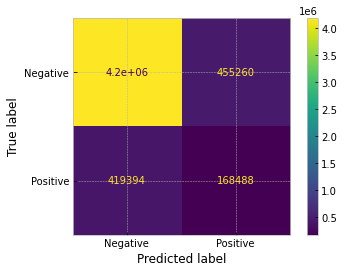

In [16]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(xgb_model_no, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos **con oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

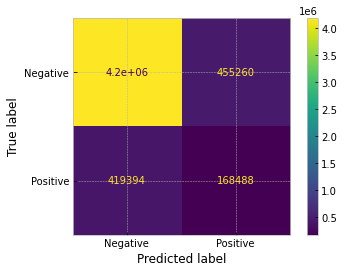

In [17]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(xgb_model_wo, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos sin **oversampling - SMOTE**

In [18]:
#Imprimimos todas las métricas en 1 - Sobre base de información sin algoritmo de SMOTE para atacar desbalanceo
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91   4648405
         1.0       0.27      0.29      0.28    587882

    accuracy                           0.83   5236287
   macro avg       0.59      0.59      0.59   5236287
weighted avg       0.84      0.83      0.84   5236287



Matríz de confusión sobre datos con **oversampling - SMOTE**

In [19]:
#Imprimimos todas las métricas en 1 - Sobre base de información sin algoritmo de SMOTE para atacar desbalanceo
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91   4648405
         1.0       0.27      0.29      0.28    587882

    accuracy                           0.83   5236287
   macro avg       0.59      0.59      0.59   5236287
weighted avg       0.84      0.83      0.84   5236287



**Resultados**

Dataset sin SMOTE u oversampling:

Nuestro precision asciende a 0.91, con lo cual, tenemos buen accuracy de predicción de clases, en este caso, clientes con Churn. Cabe destacar que este alto accuracy se debería al problema de desbalanceo, donde la clase dominante son aquellos clientes de Churn con más del 90%. 

El F1 score de la clase positiva (clientes que compran o no Churn) es muy bajo , **0.28**, mientras que de la clase negativa (Churn) vemos que es de **0.91**. 

Por otra parte, vemos que tenemos un performance similar si usamos la **técnica de oversampling SMOTE**. Tenemos los mismos accuracy de 0.91 así como un F1 score de clase negativa de 0.91 y de clase positiva de 0.28. 

Por otra parte, sí se observa una mejora en el F1 Score de la clase positiva **1** o de la clase de clientes que sí realizamos una compración directa con el modelo de **Random Forests**.


### **Entrenamiento del 3er modelo de Machine Learning : LOGISTIC REGRESSION**

Para este caso, utilizarémos un modelo de **regresión logística** para comparar el performance de dicho modelo con aquellos del tipo Bagging como Random Forests o del tipo Boosting como **XGboost**. 

Se entrenarán dichos modelos sobre la base total y la base desbalanceada. Para la evaluación mediremos Precision, Recall y F1 score de las clases positivas y negativas así como el gráfico de una matriz de confusión. 

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

#Entrenamos nuestro modelo dentro de la información
logistic_reg = LogisticRegression(solver = 'lbfgs')
logistic_reg.fit(X_train, y_train)

logistic_reg_smote = LogisticRegression(solver='lbfgs')
logistic_reg_smote.fit(X_train_over,y_train_over)


LogisticRegression()

Evaluación del modelo de clasificación de **"Logistic Regression"**

In [30]:
# Guaradmos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = logistic_reg.predict(X_train)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = logistic_reg.predict(X_test)
predictions_test['preds_over'] = logistic_reg_smote.predict(X_test)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")

Accuary datos entrenamiento: 0.8898, Accuracy datos Test: 0.8897, Accuracy test Oversampled: 0.6870


Matríz de confusión sobre datos sin **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

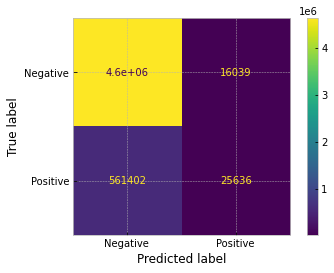

In [31]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(logistic_reg, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos con **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

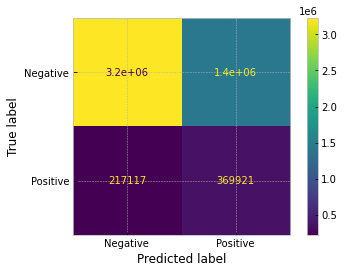

In [32]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(logistic_reg_smote, X_test, y_test, display_labels=['Negative', 'Positive'])

Reporte de Precision - Recall - F1 Score | **Datos sin oversampling - SMOTE**

In [33]:
#Imprimimos todas las métricas en 1 - Sobre base de información sin algoritmo de SMOTE para atacar desbalanceo
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94   4649249
         1.0       0.62      0.04      0.08    587038

    accuracy                           0.89   5236287
   macro avg       0.75      0.52      0.51   5236287
weighted avg       0.86      0.89      0.84   5236287



Reporte de Precision - Recall - F1 Score | **Datos con oversampling - SMOTE**

In [34]:
#Imprimimos todas las métricas en 1
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80   4649249
         1.0       0.21      0.63      0.31    587038

    accuracy                           0.69   5236287
   macro avg       0.57      0.66      0.55   5236287
weighted avg       0.86      0.69      0.74   5236287



**Resultados**

Dataset sin **SMOTE u oversampling**:

Vemos que el accuracy del test set y el training set sin oversampling es de 0.88, mientras que con el oversampling | SMOTE el accuracy baja a 0.68.

**Sin SMOTE | Oversampling:**
El F1 score de la clase positiva (clientes que compran o no Churn) es muy bajo , **0.08**, mientras que de la clase negativa (Churn) vemos que es de **0.94**. Vemos que la capacidad del modelo por predecir la clase positiva es óptima por el bajo grado de F1 Score. 

Por otra parte, vemos que tenemos un performance igual si usamos la **técnica de oversampling SMOTE**. Tenemos los mismos accuracy de 0.69 así como un F1 score de clase negativa de 0.31 y de clase positiva de 0.8. Por otra parte, vemos que el performance del F1 score sobre la clase positiva aumenta de **0.08** a **0.31**. Se mejora el performance de predicción sobre esta clase con el uso de SMOTE a **costa de bajar el accuracy**.

### **Conclusión de entrenamiento de modelos de ML y selección de Modelo**

**Conclusión de entrenamiento de modelos:**

Estos datos solo consideran el algoritmo con **Oversampling | SMOTE**

**Random Forests**:

- Accuracy test: 0.78
- F1 Clase positiva: 0.17
- F1 Clase negativa: 0.87
- Precision Clase positiva: 0.12
- Precision Clase negativa: 0.94
- Recall Clase positiva: 0.32
- Recall Clase negativa: 0.82

**XGBoost**:

- Accuracy test: 0.83
- F1 Clase positiva: 0.28
- F1 Clase negativa: 0.91
- Precision Clase positiva: 0.27
- Precision Clase negativa: 0.91
- Recall Clase positiva: 0.29
- Recall Clase negativa: 0.90

**Logistic Regression**:

- Accuracy test: 0.69
- F1 Clase positiva: 0.31
- F1 Clase negativa: 0.80
- Precision Clase positiva: 0.21
- Precision Clase negativa: 0.94
- Recall Clase positiva: 0.63
- Recall Clase negativa: 0.69

**Conclusiones**: 

En términos de accuracy, el modelo de regresión Logística tiene **el menor performance**, **0.69**. Por otra parte, el modelo XGBoost es quien mejor performance tiene considerando dicha métrica, con un valor de 0.83. 

Por otra parte, cabe destacar que el modelo de regresión Logística tiene un **F1 Score de clase positiva de 0.31**, 3 puntos porcentuales más que  XGBoost, por lo que **Logistic regression** tendría mejor capacidad de predecir las clases positivas. En cuanto a la clase negativa, **XGBoost** tendría un mejor performance de predicción respecto a esta clase

En términos de precision de clase positiva, **XGboost tiene un mejor indicador con 0.27** en comparación con Random Forests y XGboost. Para la clase negativa,los tres modelos tienen números muy similares, **0.94 para regresión y logística y Random Forest, mientras que 0.91 para XGboost**.

En cuanto a recall de clase positiva, regresión logística presenta un mejor performance de hasta **2x en comparación con XGboost y Logistic Regression**. En relación a la clase negativa, **Logistic Regression** presenta el menor del performance contra **XGBoost y Random Forests (0.69 vs 0.90 y 0.82 respectivamente)**.

Con lo anterior, vemos que XGboost presenta el mejor performance en términos generales contra los demás modelos de Bagging (Random Forests) o Regresión Logística. Presenta un mejor accuracy, de 0.83; el F1 Score y su capacidad de manejar las predicciones de la clase positiva es mejor que Random Forest y similar en Logistic Regressioon. La clase negativa también tiene el mejor performance. Con esto, **seleccionamos el modelo de XGBoost para nuestro algoritmo de predicción de Churn**.



### **Feature extraction: Reducción de dimensionalidad**

Dentro del proceso de feature engineering, en el pasado, tuvimos la oportunidad de utilizar **Backward and Forward elimination** para seleccionar las variables más relevantes dentro de nuestro modelo de Machine Learning a través de la métrica de F1 Score. Este método formó parte del proceso de **"Feature Selection"** del tipo **"Wrapper methods"**.

En la siguiente sección, utilizaremos un modelo Basado en **Feature Extraction**, el cual, extrae variables relevantes como una combinación lineal de las variables originales con menor número de dimensiones. **El método a utilizar será PCA**. 

En la siguiente sección, utilizaremos el modelo seleccionado en la sección anterior denominado **XGBoost** para entrenar nuestro modelo de machine learning con variables procesadas a través de **PCA**. Para este caso particular, utilizaremos los datos sin **OVERSAMPLING - SMOTE** para aplicar la técnica de reducción de dimensionalidad.  

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Análisis de la varianza explicada para cada componente. 

In [14]:
#Análisis de la varianza explicada para cada componente
explained_variance = pca.explained_variance_ratio_
explained_variance

array([6.53005472e-01, 1.53514893e-01, 1.03007667e-01, 8.41313046e-02,
       5.52523427e-03, 6.10655012e-04, 1.68298537e-04, 3.64757637e-05])

**Insight**: De la matriz de exploración de la explicación de varianza, vemos que los **primeros dos componentes**, en conjunto, explican alrededor del **80% de la varianza del conjunto de datos original**.

El tercero **explica un 10% de la varianza**, el cuarto componente explica solo **8%** y así consecutivamente. 

### **Entrenamiento del modelo de Machine Learning (XGBoost) con las componentes principales**



Dentro del modelo de ML, utilizaremos el modelo XGBoost para entrenar nuestro modelo con solo **dos componentes principales del PCA**, los cuales, agruparían el 80% de la varianza del data set original.

Cabe remarcar que para este ejercicio usaremos la información **sin oversampling con SMOTE**.

In [15]:
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import metrics


#Obtenemos solo los dos principales componentes
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#Entrenamos el modelo sobre la base de información imbalanceada
xgb_model =  xgb.XGBClassifier(learning_rate = 0.1, random_state = 42)

#We train over the data set that is not oversampled.
xgb_model_no = xgb_model.fit(X_train_pca, y_train)


Evaluación del modelo de clasifiación XGBoost con las nuevas variables del PCA.

In [16]:
# Guardamos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = xgb_model_no.predict(X_train_pca)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = xgb_model_no.predict(X_test_pca)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}")

Accuary datos entrenamiento: 0.8883, Accuracy datos Test: 0.8881


Matriz de confusión

<Figure size 864x288 with 0 Axes>

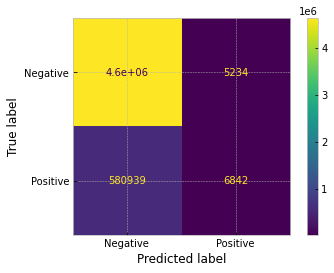

In [17]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(xgb_model_no, X_test_pca, y_test, display_labels=['Negative', 'Positive'])

Reporte de Precision - Recall - F1 Score | **Datos sin oversampling - SMOTE**

In [18]:
#Imprimimos todas las métricas en 1 - Sobre base de información sin algoritmo de SMOTE para atacar desbalanceo
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94   4648506
         1.0       0.57      0.01      0.02    587781

    accuracy                           0.89   5236287
   macro avg       0.73      0.51      0.48   5236287
weighted avg       0.85      0.89      0.84   5236287



**Insight**: Información sobre el data set test

**Modelo de XGBoost sin PCA:**

Accuracy: 0.88

- F1 Score positivo:0.28
- F1 Score negativo:0.91

- Precision positivo:0.27
- Precision negativo:0.91

- Recall positivo:0.29
- Recall negativo:0.90

**Modelo de XGBoost con PCA:**

Accuracy:0.89

- F1 Score positivo: 0.02
- F1 Score negativo: 0.94

- Precision positivo: 0.57
- Precision negativo:0.89

- Recall positivo: 0.01
- Recall negativo: 1.0

En general, en ambos escenarios del entrenamiento del modelo con PCA y no PCA, observamos un accuracy similar o casi igual del 0.89.

Sin embargo, me gustaría observar más de cerca los indicadores F1 Scores, donde tenemos una **dimisniución significativa de la predicción de la clase positiva**, **sin PCA teníamos 0.28, ahora con PCA, 0.02**. Esto es importante destacar y de atacar en futuros pasos de cara a la liberación de un modelo productivo.

Un path-to-follow es realizar este mismo ejercicio de utilizar PCA pero con la implementación de SMOTE.